## Making a TIFF File

This notebook  shows how to  create a custom TIFF file for our analysis.  The idea being that we want to look at only  certain pixels in a fuel map .  For example, when looking at vegetation to fuel mapping, we want to look at those fuel pixels that  correspond to a given vegetation type.

The steps:
1.  Perform analysis to determine which pixels you want to look at.  Find the index  of those pixels
2.  Import a "clean" version of the  fuel map.  We will use this as  a template
3.  For every pixel not in your Index, replace the label with  0 aka "no data"
4.  Export to XYZ file
5.  Convert XYZ file to TIFF

Then you want to scp  the file to your local computer , load it into QGIS, overlay it with the satelite image (from the corresponding year) and  view the  results.  Instructions for that are in a different file

Note:  This will only work if you import the  coordinates as strings.  If you import them as floats they will  be rounded  which will  mess up the gridding and prevent the conversion to tiff.

** For this notebook, we will be  creating a  custom TIFF file to look at fuel pixels  in 2012 that correspond to  vegetation type  "Developed-Medium Instensity" (veg=3297).  Please note that I am working with files in NAD83 but the concept is the same for WGS84 **

In [17]:
import gdal
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def ImportXYZ(FileName,labelName):
    DF=pd.read_table(FileName, header=None)
    DF.columns=['Row']
    DF["Eastern"]=DF["Row"].apply(lambda x: float(x.split(" ")[0]))
    DF["Northern"]=DF["Row"].apply(lambda x: float(x.split(" ")[1]))
    DF[labelName]=DF["Row"].apply(lambda x: x.split(" ")[2])
    del DF["Row"]
    return DF

In [6]:
clip='WIFIRE/Data_Prep_Work_Flow/Clipped_Files/'

-----------
Analysis:  Find the Pixels that you want to  view

In [2]:
#Import Veg and Fuel "decoder ring"
DecodeFuel=pd.read_csv('WIFIRE/Data_labels/fuel_labels.csv')
DecodeVeg=pd.read_csv('WIFIRE/Data_labels/veg_labels.csv')

DecodeFuel.columns=["filename",'id','fuelLabel']
DecodeVeg.columns=["id","vegLabel"]

In [7]:
#Import Fuel and Veg maps from 2012
Fuel2012=ImportXYZ(clip+'Fuel2012_Escondido_UTM.xyz','Fuel2012')
Veg2012=ImportXYZ(clip+'Veg2012_Escondido_UTM.xyz','Veg2012')

Join12=pd.merge(Veg2012,Fuel2012,on=['Eastern','Northern'],how='inner')
print(Fuel2012.shape)
print(Veg2012.shape)
print(Join12.shape)

# Add Fuel and Veg text labels
Join12['Veg2012']=Join12['Veg2012'].apply(lambda x: int(x))
Join12['Fuel2012']=Join12['Fuel2012'].apply(lambda x: int(x))
Join12=pd.merge(pd.merge(Join12,DecodeVeg,left_on='Veg2012', right_on='id',how='left'),DecodeFuel,left_on='Fuel2012',right_on='id',how='left')
Join12.head()

(154671, 3)
(154671, 3)
(154671, 4)


,Eastern,Northern,Veg2012,Fuel2012,id_x,vegLabel,filename,id_y,fuelLabel
0,480802.714908,3.667607e+06,3092,1,3092,Southern California Coastal Scrub,FBFM1,1,Short Grass
1,480832.704725,3.667607e+06,3184,1,3184,California Annual Grassland,FBFM1,1,Short Grass
2,480862.694541,3.667607e+06,3299,91,3299,Developed-Roads,Urban,91,Urban
3,480892.684358,3.667607e+06,3297,91,3297,Developed-Medium Intensity,Urban,91,Urban
4,480922.674174,3.667607e+06,3914,91,3914,Western Warm Temperate Urban Shrubland,Urban,91,Urban


In [8]:
def PlotHist(VegID,VType):
    Join12[Join12["Veg2012"]==VegID].groupby("fuelLabel")["filename"].count().plot(kind='bar')
    plt.title('Vegetation = ' + VType, fontsize=14)

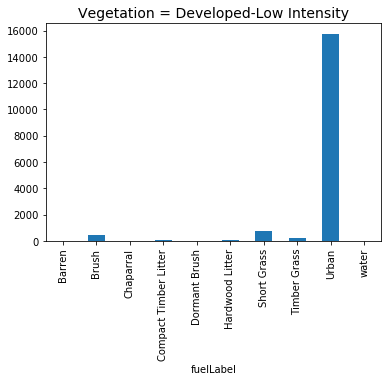

In [11]:
PlotHist(3296,'Developed-Low Intensity')

As you can see from the histogram , Developed-Low Instensity  maps to Urban.  However, there is some noise that could be potential mislabels in the data.  We want to  look at  the pixels corresponding to  Developed-Low Instensity overlayed on the  2012 satellite images that we are using in our model. 

In [12]:
# Collect the Index for fuel pixels corresponding to Developed-Low Intensity
Fuel2012["IndexFuel"]=Fuel2012.index
Index3297=Join12[(Join12["Veg2012"]==3297)].index

------
2) Import a  "clean" version of the Fuel map

In [13]:
# Import the fuel map keeping the coordinates as strings so as not to lose precision with float conversion
def ImportPreserve(FileName,labelName):
    DF=pd.read_table(FileName, header=None)
    DF.columns=['Row']
    DF["Eastern"]=DF["Row"].apply(lambda x: x.split(" ")[0])
    DF["Northern"]=DF["Row"].apply(lambda x: x.split(" ")[1])
    DF[labelName]=DF["Row"].apply(lambda x: x.split(" ")[2])
    del DF["Row"]
    return DF

In [14]:
PreserveFuel2012=ImportPreserve(clip+'Fuel2012_Escondido_UTM.xyz','Fuel2012')
PreserveFuel2012["IndexFuel"]=PreserveFuel2012.index

____
3)  For every pixel not in your Index, replace the label with  0 aka "no data"

In [15]:
Hold=[]
for index, row in PreserveFuel2012.iterrows():
    if row["IndexFuel"] not in Index3297:
        a='0'
    else:
        a=row["Fuel2012"]
    Hold.append(a)

DF3297=pd.concat([PreserveFuel2012,pd.DataFrame(Hold,columns=['NewFuel'])],axis=1)

----
4) Export to XYZ file

In [16]:
DF3297[["Eastern", "Northern","NewFuel"]].to_csv('Fuel2012_WhenVeg3297.xyz',sep=' ', index=False, header=False)

----
5) Convert XYZ file to TIFF

In [18]:
gdal_str="/opt/anaconda3/bin/gdal_translate Fuel2012_WhenVeg3297.xyz Fuel2012_WhenVeg3297.tif"
os.system(gdal_str)

0

Note that if  a GDAL command  (implemented via os.system) returns 0 then it executed.  If it returns something else then there was an error.  Switch to command line to view the error

Now let's do a quick check to make sure everything worked properly

In [19]:
#Original histogram:
DF3297["NewFuel"].astype(float).value_counts()

0.0     138823
91.0     12594
1.0       1504
5.0       1005
2.0        601
8.0         79
9.0         35
99.0        28
98.0         2
Name: NewFuel, dtype: int64

In [20]:
# New file's histogram
Test=ImportXYZ('Fuel2012_WhenVeg3297.xyz','Fuel2012')
Test["Fuel2012"].astype(float).value_counts()

0.0     138823
91.0     12594
1.0       1504
5.0       1005
2.0        601
8.0         79
9.0         35
99.0        28
98.0         2
Name: Fuel2012, dtype: int64

In [21]:
Test.head()

,Eastern,Northern,Fuel2012
0,480802.714908,3.667607e+06,0
1,480832.704725,3.667607e+06,0
2,480862.694541,3.667607e+06,0
3,480892.684358,3.667607e+06,91
4,480922.674174,3.667607e+06,0


Everything looks good.  Now it is time to download the file via scp and  switch to QGIS